In [1]:
import pandas as pd
import csv
import numpy as np
import re
!pip install transformers
!pip install torchinfo
from transformers import AutoTokenizer
from torch.optim import AdamW
from transformers import BertConfig, BertModel
from torch import nn
import torch
import math
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup
from torchinfo import summary
from matplotlib import pyplot as plt
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Preprocessing

In [2]:
# Read training file
df = pd.read_csv("https://raw.githubusercontent.com/MMU-TDMLab/CompLex/master/train/lcp_single_train.tsv",
                 delimiter="\t", quoting=csv.QUOTE_NONE, encoding='utf-8')
df = df.replace(np.nan, 'null')
df = df.sample(frac=1).reset_index(drop=True)

# Remove columns ID and Corpus
df = df[['sentence', 'token', 'complexity']]

# Lowercase sentence and token column in dataframe
df['token'] = df['token'].str.lower() 
df['sentence'] = df['sentence'].str.lower()

# Convert columns to list
sentences = df['sentence'].tolist()
tokens = df['token'].tolist()
complexities = df['complexity'].tolist()

In [3]:
df

,sentence,token,complexity
0,these include signs of neurologic dysfunction ...,difficulties,0.138889
1,"the lord is not slow concerning his promise, a...",slowness,0.303571
2,"you will be handed over even by parents, broth...",parents,0.078125
3,sheshan gave his daughter to jarha his servant...,wife,0.264706
4,"you sons of men, how long shall my glory be tu...",dishonor,0.250000
...,...,...,...
7657,"is it any pleasure to the almighty, that you a...",almighty,0.235294
7658,very important lessons have been drawn from cr...,solutions,0.285714
7659,"firstly, we are concerned about the implicatio...",party,0.214286
7660,"this region contains several genes, including ...",causation,0.593750


In [4]:
# Used for preprocessing
class preprocessing():
    def __init__(self, sentences, tokens, complexities):
        self.tokens = tokens
        self.sentences = sentences
        # Convert complexity list to tensor
        self.complexity = torch.Tensor(complexities)

        self.remove_websites()
        self.remove_punctuation()
        
    # Remove any punctuation                                                  
    def remove_punctuation(self):
        # Loop through each index and update text in index without punctuation
        for index in range(0, len(self.sentences)):
            sentence = self.sentences[index]
            text = re.sub(r'[^\w\s]',"", sentence)
            self.sentences[index] = text
    # Remove website links
    def remove_websites(self):
        # Loop through each index and update text in index without websites
        for index in range(0, len(self.sentences)):
            sentence = self.sentences[index]
            text = re.sub(r'(http\:\/\/|https\:\/\/)?([a-z0-9][a-z0-9\-]*\.)+[a-z][a-z\-]*', "", sentence)
            self.sentences[index] = text

In [5]:
pp = preprocessing(sentences, tokens, complexities)

### Tokenizer and Apply Padding

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

#### Sentences

In [7]:
# Create a sentence tokenizer using AutoTokenizer above with min/max length of 85
encoded_sentences = tokenizer(pp.sentences, padding="max_length", max_length=85, truncation=True)
input_ids_sentences = encoded_sentences['input_ids']
attention_mask_sentences = encoded_sentences['attention_mask']

#### Token

In [8]:
# Create a token tokenizer using AutoTokenizer above with min/max length of 85
encoded_tokens = tokenizer(pp.tokens, padding="max_length", max_length=85, truncation=True)
input_ids_tokens = encoded_tokens['input_ids']
attention_mask_tokens = encoded_tokens['attention_mask']

### Create Train & Validation Split and Convert to DataLoaders

In [9]:
# Used to create dataloaders and tensor datasets
def dataloaders(sentences_id, sentence_masks, labels, token_id, token_mask, batch_size, split_size):
    
    # Determine training set size
    train_size = math.floor(len(sentences_id) * (1 - split_size))
    
    # Create training and validation set sizes for sentence input and masks
    train_sent_inputs = torch.tensor(sentences_id[:train_size])
    val_sent_inputs = torch.tensor(sentences_id[train_size:])
    train_sent_masks = torch.tensor(sentence_masks[:train_size])
    val_sent_masks = torch.tensor(sentence_masks[train_size:])
    
    # Create training and validation set sizes for token input and masks
    train_token_inputs = torch.tensor(token_id[:train_size])
    val_token_inputs = torch.tensor(token_id[train_size:])
    train_token_masks = torch.tensor(token_mask[:train_size])
    val_token_masks = torch.tensor(token_mask[train_size:])
    
    # Create training and validation set sizes for labels
    train_labels = torch.tensor(labels[:train_size])
    val_labels = torch.tensor(labels[train_size:])
    
    # Create a tensordataset for training and validation
    train_data = TensorDataset(train_sent_inputs, train_sent_masks, train_labels, train_token_inputs, train_token_masks)
    val_data = TensorDataset(val_sent_inputs, val_sent_masks, val_labels, val_token_inputs, val_token_masks)
    
    # Create a dataloader for training and validation with a specific batch size
    train_dataloader = DataLoader(dataset = train_data, batch_size = batch_size)
    val_dataloader = DataLoader(dataset = val_data, batch_size = batch_size)
    return train_dataloader, val_dataloader

In [10]:
# Batch size
batch_size = 32
# training/validation split
split_size = 0.10
# Create dataloaders and tensordatasets
train_dataloader, val_dataloader = dataloaders(input_ids_sentences, attention_mask_sentences, complexities, 
                                        input_ids_tokens, attention_mask_tokens, batch_size, split_size)

### Model

In [11]:
# Class to create BERT model
class Bert_Model(torch.nn.Module):
    def __init__(self, input_dim, config):
        super().__init__()
        
        # BERT models for sentence and token
        self.sent_emb = BertModel(config)
        self.token_emb = BertModel(config)
        
        # Linear Layer for BERT Model outputs
        self.cls = nn.Linear(2 * 768, 1)
        # Sigmoid activation for linear layers
        self.sigmoid = nn.Sigmoid()

    def forward(self, sent_id, sent_mask, token_id, token_mask):
        # BERT for sentence
        # Retrieve the prediction BERT for sentence
        sent_embed = self.sent_emb(sent_id,sent_mask)[1]
        sent_embed = sent_embed.view(sent_embed.shape[0], -1)
        # apply 0.20 weight to BERT for Sentence
        sent_embed = torch.mul(sent_embed, 0.20)

        # BERT for token
        # Retrieve the prediction BERT for token
        token_embed = self.token_emb(token_id,token_mask)[1]
        token_embed = token_embed.view(token_embed.shape[0], -1)
        # apply 0.80 weight to BERT for Token
        token_embed = torch.mul(token_embed, 0.80)
        
        # Concat the results from BERT models
        last_hidden_state = torch.cat([sent_embed, token_embed], dim=1)
        # Apply linear layer
        output = self.cls(last_hidden_state)
        # Apply sigmoid function
        y_pred = self.sigmoid(output)
        return y_pred

In [12]:
# Used for validation loss
def evaluate(model, val_dataloader):
    model.eval()
    total_loss = 0
    count = 0
    # Loop through each val_dataloader batch
    for step, batch in enumerate(val_dataloader):
        # Retrieve the data
        sent_id, sent_mask, labels, token_id, token_mask = tuple(b.to(device) for b in batch)
        # Retrieve prediction
        outputs = model(sent_id, sent_mask, token_id, token_mask)
        # Retrieve the loss
        val_loss = mae_loss(outputs.squeeze(), labels.squeeze())
        # Add loss to the total loss
        total_loss += val_loss.item()

        count += 1

        # Print loss for every 100 step
        if step % 100 == 0:
            print("Validation Step: " + str(step))  
            print("Validation Loss: " + str(val_loss.item()))
    avg_loss = total_loss/count
    return val_loss, avg_loss

In [13]:
# Used to find MAE loss
def mae_loss(outputs, labels):
    subtract = torch.subtract(outputs, labels)
    absolute_val = torch.abs(subtract)
    sum_all = torch.sum(absolute_val)
    return torch.div(sum_all, outputs.shape[0])

In [14]:
# Used to train model
def train(model, optimizer, scheduler, epochs, train_dataloader, val_dataloader, device):
    # list to hold final val and training losses
    avg_val_losses = []
    avg_train_losses = []
    print("---------------------------------------------------------------------------------------------------")
    # Go through the epochs
    for epoch in range(epochs):
        print("Epoch " + str(epoch + 1))
        print("---------------------------------------------------------------------------------------------------")
        model.train()
        total_loss = 0
        count = 0
        # Go through each batch
        for step, batch in enumerate(train_dataloader): 
            # Retrieve the data for each batch
            sent_id, sent_mask, labels, token_id, token_mask = tuple(b.to(device) for b in batch)
            model.zero_grad()
            # Retrieve prediction 
            outputs = model(sent_id, sent_mask, token_id, token_mask)
            # Retrieve loss value
            loss = mae_loss(outputs.squeeze(), labels.squeeze())
            # Add to total loss
            total_loss += loss.item()
            
            # Update gradient and optimizer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            count += 1
            
            # Print loss for every 100 step
            if step % 100 == 0:
                print("Train Step: " + str(step))  
                print("Train Loss: " + str(loss.item()))
                
        print("Final Step Loss: "  + str(loss.item()))
        print()
        
        # Find validation loss
        val_loss, avg_val_loss = evaluate(model, val_dataloader)
        
        print("Final Validation Loss: " + str(val_loss.item()))
        print()
        print('Average Loss: ' + str(total_loss/count))
        print("Average Validation Loss: " + str(avg_val_loss))
        print("---------------------------------------------------------------------------------------------------")
        avg_val_losses.append(avg_val_loss)
        avg_train_losses.append(total_loss/count)
    return model, avg_val_losses, avg_train_losses

In [15]:
# Configuration for BERT Model
config = BertConfig(max_position_embeddings = 85, hidden_act = 'relu', hidden_dropout_prob = 0.15, attention_probs_dropout_prob = 0.15, classifier_dropout = 0.25)
# Create BERT Model object
model = Bert_Model(768, config)

In [16]:
# Initalize Optimizer
optimizer = AdamW(model.parameters(), lr=5e-6, eps=1e-8)

In [17]:
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
# Set as CUDA For now
device = torch.device("cuda")
model.to(device)
# Train model and retrieve results
final_model, val_losses, train_losses = train(model, optimizer, scheduler, epochs, train_dataloader, val_dataloader, device)

---------------------------------------------------------------------------------------------------
Epoch 1
---------------------------------------------------------------------------------------------------
Train Step: 0
Train Loss: 0.2379750907421112
Train Step: 100
Train Loss: 0.08061496168375015
Train Step: 200
Train Loss: 0.08142463862895966
Final Step Loss: 0.09780245274305344

Validation Step: 0
Validation Loss: 0.07347598671913147
Final Validation Loss: 0.11760220676660538

Average Loss: 0.09359003679343948
Average Validation Loss: 0.09494904335588217
---------------------------------------------------------------------------------------------------
Epoch 2
---------------------------------------------------------------------------------------------------
Train Step: 0
Train Loss: 0.07802407443523407
Train Step: 100
Train Loss: 0.08826091885566711
Train Step: 200
Train Loss: 0.08087821304798126
Final Step Loss: 0.0945693850517273

Validation Step: 0
Validation Loss: 0.071431465

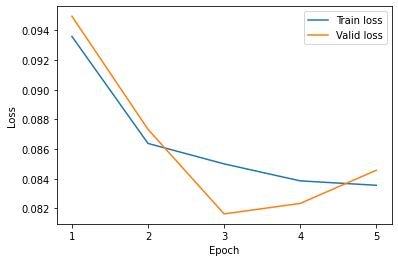

In [18]:
%matplotlib inline

x = np.arange(1, len(train_losses) + 1)
plt.plot(x, train_losses, label='Train loss')
plt.plot(x, val_losses, label='Valid loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

In [19]:
summary(model)

Layer (type:depth-idx)                                  Param #
Bert_Model                                              --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              65,280
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─BertModel: 1-2                                        --
│    └─BertEmbeddings: 2-4                              --
│    │    └─Embeddin

In [20]:
from google.colab import drive
drive.mount('/content/drive')

# Save model parameters
torch.save(model.state_dict(), '/content/drive/MyDrive/NLPProject/model.pth')
print("Sucessfully Saved Model Parameters")

Mounted at /content/drive
Sucessfully Saved Model Parameters
